__Adderar nytt data för att uppdatera modellen. Nytt data från 2019 och framåt__


__Ny modell. Nu delar vi upp datat på omgångarna, inte slumpmässigt. Totalt 222 omgångar. Bygger modell på 175 omgångar, validerar på de övriga. Imputerar för missing innan vi kör modellen, tar bort detta steg från data pipelinen. Vi läser även in VNUM som är rankingen efter spelade hästar för att jämföra med den framtagna modellen__

__Tar fram optimal modell med cross validering och en randomforrest. Först en modell bara på v75% och VNUM för att plocka 21 hästar. Sedan en andra modell som använder Leffes rankingar för att idenfiera de hästar som inte fångas u__

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn.model_selection import GridSearchCV 

In [3]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)

In [5]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
df0 = pd.read_excel('DataV75TillUffe_2019-02-01_2.xlsx')

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994 entries, 0 to 17993
Data columns (total 38 columns):
Datum          17994 non-null datetime64[ns]
Utdelning      17994 non-null int64
Arstid         17994 non-null int64
Distans        17994 non-null int64
Startsatt      17994 non-null int64
Lopp           17994 non-null int64
Plac           17994 non-null int64
Hast           17994 non-null int64
V75PROC        17994 non-null float64
V_ODDS         17994 non-null float64
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null in

In [7]:
df0.Datum.max()

Timestamp('2019-01-05 00:00:00')

In [8]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df0['cdate'] = df0.Datum.astype('object')
df0['cLopp'] = df0.Lopp.astype('object')

In [9]:
df0['Key'] = df0['cdate'].astype(str) + df0['cLopp'].astype(str)

__Skapar en målvariabel - vinnare__

In [10]:
df0['Y'] = np.where(df0['Plac'].isin([1]), 1,0)

__Plockar bort de variabler som inte ska med__

In [11]:
# Alla analysvariabler
df1 = df0.copy(deep = True)
df1 = df1. \
drop(['Utdelning','Plac','cdate','cLopp','V_ODDS','S_R', \
      'TK_R','Arstid','Distans','Startsatt','SP_R','Ex_R','R_R','P_R'], axis = 1). \
copy().set_index(['Key'])

__Läser in nytt data från leif__

In [12]:
df0_1 = pd.read_excel('UppdateradData.xlsx')

In [13]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df0_1['cdate'] = df0_1.Datum.astype('object')
df0_1['cLopp'] = df0_1.Lopp.astype('object')

In [14]:
df0_1['Key'] = df0_1['cdate'].astype(str) + df0_1['cLopp'].astype(str)

In [15]:
df0_1['Y'] = np.where(df0_1['Plac'].isin([1]), 1,0)

In [16]:
df1_1 = df0_1.copy(deep = True)
# Alla analysvariabler
df1_1 = df1_1. \
drop(['Plac','cdate','cLopp','V_ODDS', \
      'TK_R','Arstid','Distans','Startsatt','SP_R','Ex_R','R_R','P_R'], axis = 1). \
copy().set_index(['Key'])

In [17]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1723 entries, 2019-01-12 00:00:001 to 2019-04-21 00:00:007
Data columns (total 27 columns):
Datum          1723 non-null datetime64[ns]
Lopp           1723 non-null int64
Hast           1723 non-null int64
V75PROC        1723 non-null float64
GRUPP          1723 non-null int64
VLP            1723 non-null float64
VNUM           1723 non-null int64
SVLP           1723 non-null float64
VSVLP          1723 non-null float64
VPN_SUM        1723 non-null float64
VPN_SUM_ORD    1723 non-null int64
VPK_SUM        1723 non-null float64
VPK_SUM_ORD    1723 non-null int64
VLPB           1723 non-null float64
SVLPB          1723 non-null float64
VSVLPB         1723 non-null float64
E_P            1723 non-null float64
E_P_Num        1723 non-null int64
E_N            1723 non-null float64
E_R            1723 non-null float64
E_U            1723 non-null float64
G_R            1723 non-null int64
A_R            1641 non-null float64
T_R            1723 n

__Nu konkatinerar vi ihop dessa datamängder och uppdaterar modellen__

In [18]:
df1 = pd.concat(([df1, df1_1]), axis = 0)

In [19]:
df1.Datum.max()

Timestamp('2019-04-21 00:00:00')

In [20]:
# Iterera över varje kolumn och använd logiken nedan
# Checkar dessa variabler [G_R , A_R, ToR , P_R ]
# Skapar en lista som håller de unika datumen för dessa när missing förekommer
# Tar sedan bort dessa lopp och bygger modell på de kvarvarande

In [21]:
df1['mflag1'] = np.where(df1.G_R.isna(),True,False)
df1['mflag2'] = np.where(df1.A_R.isna(),True,False)
df1['mflag3'] = np.where(df1.ToR.isna(),True,False)

In [22]:
df_delete = df1[(df1.mflag1 | df1.mflag2 | df1.mflag3)]

In [23]:
len(df_delete)

3882

In [24]:
date_filter = df_delete.Datum.drop_duplicates().tolist()

In [25]:
df1 = df1[~df1.Datum.isin(date_filter)]

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15835 entries, 2016-07-26 00:00:001 to 2019-04-21 00:00:007
Data columns (total 30 columns):
Datum          15835 non-null datetime64[ns]
Lopp           15835 non-null int64
Hast           15835 non-null int64
V75PROC        15835 non-null float64
GRUPP          15835 non-null int64
VLP            15835 non-null float64
VNUM           15835 non-null int64
SVLP           15835 non-null float64
VSVLP          15835 non-null float64
VPN_SUM        15835 non-null float64
VPN_SUM_ORD    15835 non-null int64
VPK_SUM        15835 non-null float64
VPK_SUM_ORD    15835 non-null int64
VLPB           15835 non-null float64
SVLPB          15835 non-null float64
VSVLPB         15835 non-null float64
E_P            15835 non-null float64
E_P_Num        15835 non-null int64
E_N            15835 non-null float64
E_R            15835 non-null float64
E_U            15835 non-null float64
G_R            15835 non-null float64
A_R            15835 non-null flo

In [27]:

df1 = df1.drop(['mflag1', 'mflag2','mflag3'], axis = 1)

In [28]:
# Gör om grupp till objekt
df1['GRUPP'] = df1.GRUPP.astype('object')


__Delar upp i numeriska samt charachter attribut. Det är dessa som går in i modellen__

In [29]:
num_attribs = [] 
cat_attribs = [] 

for var, typ in zip(df1.columns[:-1], df1.dtypes[:-1]): 
    if typ == 'object': 
        cat_attribs.append(var) 
    elif (typ != 'datetime64[ns]')  & (var != 'Hast') & (var != 'Lopp'): 
        num_attribs.append(var)

In [30]:
cat_attribs

['GRUPP']

In [31]:
num_attribs

['V75PROC',
 'VLP',
 'VNUM',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'ToR',
 'Ts_R']

In [32]:
len(num_attribs)

22

__Nu bygger vi upp en pipeline__

In [33]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# Denna klass måste vi göra för att särskilja numeriska variabler mot character variabler
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [34]:
# Egen klass för att sätta dummyvariabler

class SetDummyVar(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tempdf = pd.get_dummies(X[self.attribute_names], columns = self.attribute_names)
        return tempdf.values

In [35]:
# Pipeline för numeriska variabler
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ('dummy_cat', SetDummyVar(cat_attribs)),
    ])

In [36]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
    ])

__Nu itererar vi över alla testloppen. Plockar de 24 högsta scorade hästarna__

__På VNUM__

In [37]:
cm_list = []
b_list = []
d_list = df1.Datum.drop_duplicates().tolist()
for date in d_list:
    df_test1 = df1[df1.Datum == date].drop('Datum', axis = 1)
    df_test1['Pred'] = np.where(df_test1.VNUM.isin([1,2,3]),1,0)
    df_test1['Facit'] =  np.where((df_test1.Pred == 1) & (df_test1.Y == 1) ,1,0)
    cm_list.append(df_test1.Facit.sum())
    b_list.append(df_test1.Pred.sum())

In [38]:

tp_tot = 0
out_tot = 0
for tp, tot in zip(cm_list,b_list):
    tp_tot = tp_tot + tp
    out_tot = out_tot + tot

avg = tp_tot / len(cm_list)
avg

4.876923076923077

In [39]:
avg_out_tot = out_tot/len(cm_list) 
avg_out_tot


21.0

In [40]:
# Precision
avg/avg_out_tot

0.23223443223443224

In [41]:
# Recall
avg/7

0.6967032967032968

__Genom att plocka de tre högsta i VNUM för varje lopp så hittar vi 69% av de faktiska vinnarna. Bygg en modell på Leffes travstatstik för att hitta de som VNUM inte hittar. Modellen byggs på de hästar som inte ligger i VNUM 1,2 eller 3__

In [42]:
df2 = df1[~df1.VNUM.isin([1,2,3])]    

__Nu plockar vi ut 52 (20%) v75 omgångar för att använda dem som test och utvärdera modellen på__

In [43]:
v75 = df2.Datum.drop_duplicates().to_frame()

v75['is_test']=np.random.uniform(0,1,len(v75))<=0.2

test, basedf = v75[v75['is_test']==True], v75[v75['is_test']==False]

In [44]:
# Plockar in imgångarna vi ska träna modellen på
train = df2[df2.Datum.isin(basedf.Datum.tolist())]

# De 52 vi utvärderar på 
validate = df2[df2.Datum.isin(test.Datum.tolist())]

In [45]:
num_attribs = ['VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'ToR',
 'Ts_R']

In [46]:
# Träningsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_train = full_pipeline.fit_transform(train)
## En array som håller det vi vill predikter
label_train = train["Y"].copy()

In [47]:
# Valideringsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_valid = full_pipeline.fit_transform(validate)
## En array som håller det vi vill predikter
label_valid = validate["Y"].copy()

In [48]:
param_grid = { 
    'n_estimators': [500],
    'max_leaf_nodes':[16],
    'max_features': ['sqrt', 'auto','log2'],
    'criterion': ['gini'],
    'bootstrap': [True, False],
    'n_jobs':[-1]
    
}

In [49]:
# Skapar instansen av modellen
rf_all = RandomForestClassifier()

# Instansen av gridsearc
grid_search = GridSearchCV(rf_all, param_grid, cv=5, scoring = 'roc_auc' , return_train_score=True)
# Hyperparameter oprimering
grid_search.fit(features_train, label_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'max_leaf_nodes': [16], 'max_features': ['sqrt', 'auto', 'log2'], 'criterion': ['gini'], 'bootstrap': [True, False], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [50]:
pararg = grid_search.best_params_
pararg

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'n_estimators': 500,
 'n_jobs': -1}

In [51]:
# Utvärderar styrkan i modellen - sätter hyperparametrarna och cross fold fem
rf_mod_6 = RandomForestClassifier(**pararg)
scores_opt = cross_val_score(rf_mod_6, features_train, label_train , scoring = "roc_auc", cv = 5 ) 

In [52]:
scores_opt

array([0.72846659, 0.7117613 , 0.71729339, 0.72624591, 0.70688172])

In [53]:
scores_opt.mean()

0.7181297809212241

In [54]:
# Bygger den slutliga modellen för random forrest
rf_mod_6.fit(features_train,label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
predict = rf_mod_6.predict_proba(features_valid)

In [56]:
fpr, tpr, threshold = roc_curve(label_valid,predict[:,1])

roc_auc = auc(fpr,tpr)
print(roc_auc)

0.7327657511194774


__Ny bygger vi ytterligare en modell som ska plocka ut en spik. Modellen bygger vi på VNUM 1-2 samt E_P_Num 1,2,3 vilket plockar ut sex hästar från varje omgång__



In [57]:
v75_spik = df1[(df1.VNUM.isin([1,2])) & (df1.E_P_Num .isin([1,2,3]))].Datum.drop_duplicates().to_frame()

v75_spik['is_test']=np.random.uniform(0,1,len(v75))<=0.2

test_spik, basedf_spik = v75_spik[v75_spik['is_test']==True], v75_spik[v75_spik['is_test']==False]

In [58]:
# Plockar in imgångarna vi ska träna modellen på
train_spik = df1[(df1.VNUM.isin([1,2])) & (df1.E_P_Num .isin([1,2,3])) & (df1.Datum.isin(basedf.Datum.tolist()))]

# De 52 vi utvärderar på 
validate_spik = df1[(df1.VNUM.isin([1,2])) & (df1.E_P_Num .isin([1,2,3])) & (df1.Datum.isin(test.Datum.tolist()))]

In [20]:
num_attribs = ['VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'ToR',
 'Ts_R']

In [21]:
len(num_attribs)

20

In [60]:
# Träningsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_train_spik = full_pipeline.fit_transform(train_spik)
## En array som håller det vi vill predikter
label_train_spik = train_spik["Y"].copy()

In [61]:
# Valideringsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_valid_spik = full_pipeline.fit_transform(validate_spik)
## En array som håller det vi vill predikter
label_valid_spik = validate_spik["Y"].copy()

In [62]:
param_grid = { 
    'n_estimators': [500],
    'max_leaf_nodes':[16],
    'max_features': ['sqrt', 'auto','log2'],
    'criterion': ['gini'],
    'bootstrap': [True, False],
    'n_jobs':[-1]
    
}

In [63]:
# Skapar instansen av modellen
rf_all_spik = RandomForestClassifier()

# Instansen av gridsearc
grid_search_spik = GridSearchCV(rf_all_spik, param_grid, cv=5, scoring = 'roc_auc' , return_train_score=True)
# Hyperparameter oprimering
grid_search_spik.fit(features_train_spik, label_train_spik)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'max_leaf_nodes': [16], 'max_features': ['sqrt', 'auto', 'log2'], 'criterion': ['gini'], 'bootstrap': [True, False], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [64]:
# Utvärderar styrkan i modellen - sätter hyperparametrarna och cross fold fem
rf_mod_6_spik = RandomForestClassifier(**pararg)
scores_opt_spik = cross_val_score(rf_mod_6_spik, features_train_spik, label_train_spik , scoring = "roc_auc", cv = 5 ) 

In [65]:
scores_opt_spik 

array([0.72605042, 0.7162465 , 0.72577031, 0.66106443, 0.65042373])

In [66]:
scores_opt_spik.mean()

0.6959110762949247

In [67]:
# Bygger modellen för spiken

# Bygger den slutliga modellen för random forrest
rf_mod_6_spik.fit(features_train_spik,label_train_spik)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

__Nu vill utvärdera hela processen. Hur ser fördelningen ut på antalet rätt om vi plockar alla VNUM1-3 samt de 14 hästarna med högst score under dessa för att sedan plocka ut två spikar med modellen för att redfucera systemet? Då måste vi jobba med komplett valideringsdata där alla hästar ingår. Börjar med att återskapa det från df1 med hjälp av datum__

In [68]:
datum_filter = validate.Datum.values.tolist()

In [69]:
validate_all = df1[df1.Datum.isin(datum_filter)]

In [70]:
d_list = validate_all.Datum.drop_duplicates().tolist()
res_list = []
for date in d_list:
    df_test1 = validate_all[validate_all.Datum == date].drop('Datum', axis = 1)
    df_test1['GRUPP'] = df_test1.GRUPP.astype('object')
    features = full_pipeline.fit_transform(df_test1[~df_test1.VNUM.isin([1,2,3])])
    predict = rf_mod_6.predict_proba(features)
    predict_frame = pd.DataFrame({'Prob0':predict[:,0],'Prob1':predict[:,1]})
    df_lopp = predict_frame.merge(df_test1[~df_test1.VNUM.isin([1,2,3])].reset_index(), right_index = True, left_index = True)
    result = df_lopp.sort_values(['Prob1'], ascending = [False])[['Prob1','Lopp','Y']].iloc[:14].Y.sum() + df_test1[df_test1.VNUM.isin([1,2,3])]['Y'].sum()
    res_list.append(result)

__Tar fram frekvenser av utfallet__

In [71]:
# Tar fram diagram på fördelningen. True-Positive
# Gör en dataframe för att sedan gruppera

tp = {'TP':res_list}
tp_frame = pd.DataFrame.from_dict(tp)

In [72]:
tp_frame.TP.value_counts().sort_index()

3     1
4     5
5     8
6    17
7    15
Name: TP, dtype: int64

In [73]:
dist = round(tp_frame.TP.value_counts().sort_index()/len(test)*100,1)

In [74]:
dist.index.tolist()

[3, 4, 5, 6, 7]

Saving figure DistRes25


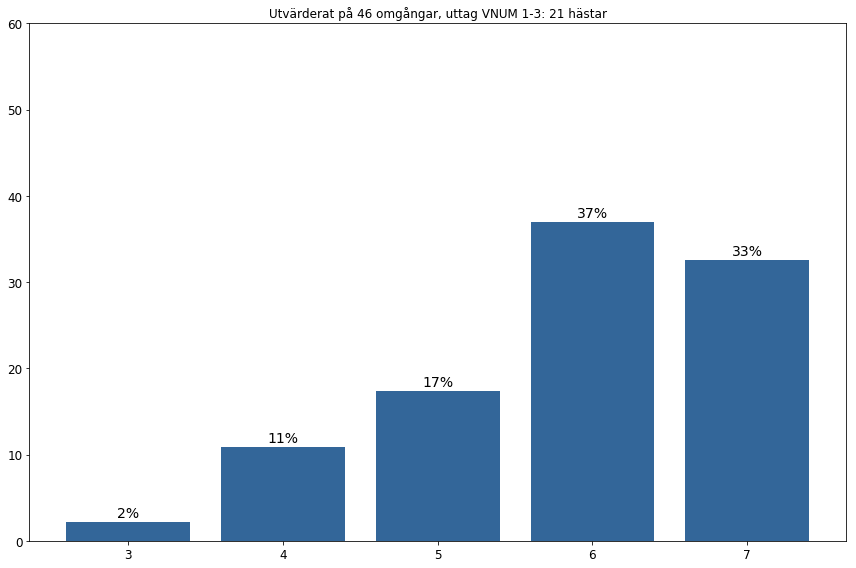

In [75]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,8))

ax1.bar(dist.index.tolist(), dist, color=(0.2, 0.4, 0.6, 1))

for x, y in zip(dist.index.tolist(), dist):
    ax1.text(x,y+0.5,str(int(round(y)))+'%', ha = 'center', fontsize=14)
    
ax1.set_title('Utvärderat på 46 omgångar, uttag VNUM 1-3: 21 hästar')

ax1.set_ybound(0,60)

save_fig('DistRes25')

Saving figure DistRes26


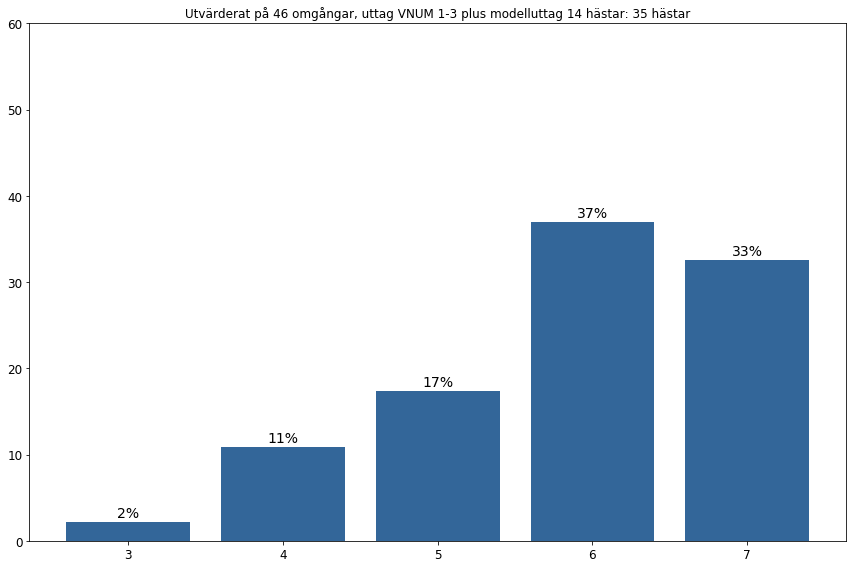

In [76]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,8))

ax1.bar(dist.index.tolist(), dist, color=(0.2, 0.4, 0.6, 1))

for x, y in zip(dist.index.tolist(), dist):
    ax1.text(x,y+0.5,str(int(round(y)))+'%', ha = 'center', fontsize=14)
    
ax1.set_title('Utvärderat på 46 omgångar, uttag VNUM 1-3 plus modelluttag 14 hästar: 35 hästar')

ax1.set_ybound(0,60)

save_fig('DistRes26')

__Nu vill vi plocka två spikar och reducera mängden rader__

In [77]:
d_list = validate_all.Datum.drop_duplicates().tolist()
res_list = []
res_list_spik = []
for date in d_list:
    df_test1 = validate_all[validate_all.Datum == date].drop('Datum', axis = 1)
    df_test1['GRUPP'] = df_test1.GRUPP.astype('object')
    features = full_pipeline.fit_transform(df_test1[~df_test1.VNUM.isin([1,2,3])])
    predict = rf_mod_6.predict_proba(features)
    
    features_spik = full_pipeline.fit_transform(df_test1[(df_test1.VNUM.isin([1,2])) & (df_test1.E_P_Num .isin([1,2,3]))])
    predict_spik = rf_mod_6_spik.predict_proba(features_spik)
    
    predict_frame_spik = pd.DataFrame({'Prob0':predict[:,0],'Prob1':predict[:,1]})
    df_lopp_spik = predict_frame_spik.merge(df_test1[(df_test1.VNUM.isin([1,2])) & (df_test1.E_P_Num.isin([1,2,3]))].reset_index(), right_index = True, left_index = True)
    
    
    predict_frame = pd.DataFrame({'Prob0':predict[:,0],'Prob1':predict[:,1]})
    df_lopp = predict_frame.merge(df_test1[~df_test1.VNUM.isin([1,2,3])].reset_index(), right_index = True, left_index = True)
    
    result = df_lopp.sort_values(['Prob1'], ascending = [False])[['Prob1','Lopp','Y']].iloc[:14].Y.sum() + df_test1[df_test1.VNUM.isin([1,2,3])]['Y'].sum()
    res_list.append(result)
    
    result_spik = df_lopp_spik.sort_values(['Prob1'], ascending = [False])[['Prob1','Lopp','Y']].iloc[:2].Y.sum()
    res_list_spik.append(result_spik)

In [78]:
df_lopp_spik.sort_values(['Prob1'], ascending = [False])[['Prob1','Lopp','Y','VNUM','E_P_Num']]

,Prob1,Lopp,Y,VNUM,E_P_Num
3,0.048003,3,0,2,1
1,0.037817,1,0,1,2
5,0.025626,7,0,2,3
0,0.024777,1,0,2,2
2,0.021159,3,1,1,1
4,0.020601,7,0,1,3


In [79]:
res_list_spik

[1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0]

In [80]:
result_spik

0

In [81]:
len(res_list_spik)

46

In [82]:
s_list = []
for i in res_list_spik:
    s_list.append(i / 2)

In [83]:
s_list

[0.5,
 0.0,
 0.5,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 1.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 0.5,
 0.0,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.0,
 1.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 0.5,
 0.0]

In [84]:
# Sedan räknar vi ut medelvärdet

mean_list = []
total = 0
for s in s_list:
    total += s
    

In [85]:
total / 46 

0.31521739130434784

In [86]:
c0 = 0
c1 = 0
c2 = 0
for s in res_list_spik:
    if s == 0:
        c0+=1
    elif s == 1:
        c1 +=1
    else:
        c2 +=1
    

In [87]:
print(c0,c1,c2)

19 25 2


__Nu bygger vi en modell på hela datamängden med de optimerade hyperparametrarna__

In [88]:
from sklearn.externals import joblib

# Pipelineobjekt
joblib.dump(full_pipeline, 'Pipeline_v7.pkl')

# Modellobjekt
joblib.dump(rf_mod_6, 'Travmodel_v7.pkl')

['Travmodel_v7.pkl']

In [90]:
dir(full_pipeline)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_param_names',
 '_get_params',
 '_iter',
 '_replace_estimator',
 '_set_params',
 '_update_transformer_list',
 '_validate_names',
 '_validate_transformers',
 'fit',
 'fit_transform',
 'get_feature_names',
 'get_params',
 'n_jobs',
 'set_params',
 'transform',
 'transformer_list',
 'transformer_weights']

In [91]:
full_pipeline.transformer_list

[('num_pipeline', Pipeline(memory=None,
       steps=[('selector', DataFrameSelector(attribute_names=['V75PROC', 'VLP', 'VNUM', 'SVLP', 'VSVLP', 'VPN_SUM', 'VPN_SUM_ORD', 'VPK_SUM', 'VPK_SUM_ORD', 'VLPB', 'SVLPB', 'VSVLPB', 'E_P', 'E_P_Num', 'E_N', 'E_R', 'E_U', 'G_R', 'A_R', 'T_R', 'ToR', 'Ts_R'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0))]))]